# image classification of fashion MNIST using residual network 

In [40]:
import tensorflow as tf
from tensorflow import keras

In [41]:
import numpy as np
import sklearn
import pandas as pd

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## load fashion MNIST dataset

In [43]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [44]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## scale dataset

In [45]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [46]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## build model

In [47]:
#residual network (ResNet)

In [48]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [49]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=3, strides=1,  #default: kernel_size=7, strides=2
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2, padding="SAME"))  #default: pool_size=3, strides=2
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6:   #default:  + [512] * 3
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 28, 28, 64)        576       
_________________________________________________________________
batch_normalization_65 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
residual_unit_29 (ResidualUn (None, 14, 14, 64)        74240     
_________________________________________________________________
residual_unit_30 (ResidualUn (None, 14, 14, 64)        74240     
_________________________________________________________________
residual_unit_31 (ResidualUn (None, 14, 14, 64)       

## compile model

In [51]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

## train model

In [52]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 217s 121ms/step - loss: 0.5898 - accuracy: 0.8084 - val_loss: 0.3427 - val_accuracy: 0.8768
Epoch 2/10
1719/1719 [==============================] - 189s 110ms/step - loss: 0.2673 - accuracy: 0.9032 - val_loss: 0.2615 - val_accuracy: 0.9002
Epoch 3/10
1719/1719 [==============================] - 188s 110ms/step - loss: 0.2275 - accuracy: 0.9188 - val_loss: 0.2316 - val_accuracy: 0.9140
Epoch 4/10
1719/1719 [==============================] - 188s 109ms/step - loss: 0.1921 - accuracy: 0.9296 - val_loss: 0.2132 - val_accuracy: 0.9196
Epoch 5/10
1719/1719 [==============================] - 187s 109ms/step - loss: 0.1690 - accuracy: 0.9392 - val_loss: 0.2205 - val_accuracy: 0.9188
Epoch 6/10
1719/1719 [==============================] - 188s 109ms/step - loss: 0.1368 - accuracy: 0.9487 - val_loss: 0.2481 - val_accuracy: 0.9168
Epoch 7/10
1719/1719 [==============================] - 186s 108ms/step - loss: 0.1165 - accuracy: 0.9572 - val_

## learning curves

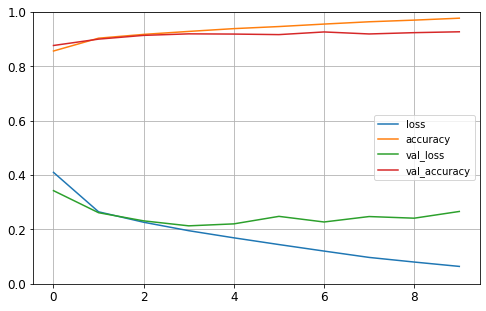

In [53]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
val_acc = history.history['val_accuracy']

In [56]:
np.argmax(val_acc) #epoch position of maximum; attention: position counted from zero; training output counted from one.

9

In [57]:
round(np.max(val_acc),4)

0.9272

## evaluate model

In [58]:
#check generalization accuracy on the test set

In [59]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 7s 21ms/step - loss: 0.2839 - accuracy: 0.9214


In [60]:
round(score[1],4)

0.9214

## prediction

In [61]:
X_new = X_test[:10]  #new instances taken from test set

In [62]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [63]:
y_test[:10]  #check prediction

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [64]:
np.array(class_names)[y_pred]  #convert class index to class name

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

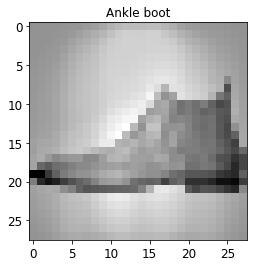

In [65]:
plt.imshow(X_new[0,...,0], cmap="binary", interpolation="nearest")
plt.title(class_names[y_test[0]], fontsize=12)
plt.show()